In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
tfd=tfp.distributions

Calculate gravity of polygon

" Computing the gravitaional and magnetic anomalies due to a polygon: Algorithems and Fortran subroutines' Won 1986


In [2]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

def B(x,z,p1,p2):
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

def theta(x,z, p):
    if x[p] != 0 :
        if(np.arctan(z[p]/x[p]))<0:
            return(np.arctan(z[p]/x[p])+scipy.pi)
        else:
            return(np.arctan(z[p]/x[p]))
    if x[p] == 0 and z[p]!=0 :
        return(scipy.pi/2)

def r(x,z,p):
    return(np.sqrt(x[p]**2+z[p]**2))

def Z(x,z,p1,p2):
    
    if x[p1] == z[p1]==0 or x[p2] == z[p2]==0:
        return(0)
    
    if x[p1] == x[p2]:
        return((x[p1]*np.log(r(x,z,p2)/r(x,z,p1))))
    
    theta1 = theta(x,z, p1)
    theta2 = theta(x,z, p2)
    
    r1 = r(x,z,p1)
    r2 = r(x,z,p2)
    
    #this is only needed when observation location across z
#     if z[p1]*z[p2]<0:
#         if x[p1]*z[p2]==x[p2]*z[p1]:
#             return(0)
#         if x[p1]*z[p2] < x[p2]*z[p1] and z[p2]>=0:
#             theta1 += 2*scipy.pi
#         if x[p1]*z[p2] > x[p2]*z[p1] and z[p1]>=0:
#             theta2 += 2*scipy.pi
    
    _A = A(x,z,p1,p2)
    _B = B(x,z,p1,p2)
    
    Z_result = _A*((theta1-theta2)+_B*np.log(r1/r2))
    return(Z_result)

Gravity at origin is calculated as $\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}$
(Won, 1987)

In [3]:
def g(data,loc=(0,0)):
    
    G = 6.67 * 10**(-11) # gravitational constant  m^3 kg ^-1 s^-2
    rho = 1000        # density difference   kg/m^3
    
    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = 0
    
    for i in range(_data.shape[0]-1):
        Z_sum += Z(_x,_z,i,i+1)

    Z_sum += Z(_x,_z,-1,0)

    g = 2*G*rho * Z_sum
    
    return(g)

In [4]:
def draw(points,ax = None,R = 100):
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
def grav_calculate(points,x=None, R=70,ax = None,style = None):
    if ax is None:
        f,ax=plt.subplots()
    if x is None:
        x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points,i))
    if style is None:
        style = '-'
    ax.plot(x,gravity,style)
    return gravity
    
def plot_true(points,R = None,ax = None):
    if R is None:
        R =max(points[:,0])
    if ax is None:
        f , ax = plt.subplots(2 , sharex = True, figsize = (7,10))
        
    grav_calculate(points, R=max(points[:,0]),ax = ax[0])
    draw(points,ax = ax[1],R=R)
    
    

<b> "note: if z is positive downward and x is positive to the right, then the polygen vertices must be specified clock-wise. " --Won 1987

In [5]:
#define a pseudo boundary condition and corner points
corners=np.array([[-200,-50],# bottom left coner
              [200,-50], 
              [200,-3], # bottom right coner
              [70, -3], # top right coner
              [-70,-3],# top left coner
              [-200,-3]])

In [6]:
corners.shape

(6, 2)

set up the problem

In [122]:
N = 10
points = np.empty((N+6,2))

for i in range(corners.shape[0]-2):
    points[i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(3)

x = np.linspace(-70,70,N+2)

y = np.random.uniform(min(corners[:,1])+10,max(corners[:,1]-10),N)

In [123]:
for i in range(N):
    points[i+4][1] = y[i]
for i in range(N):
    points[i+4][0] = x[-i-2]

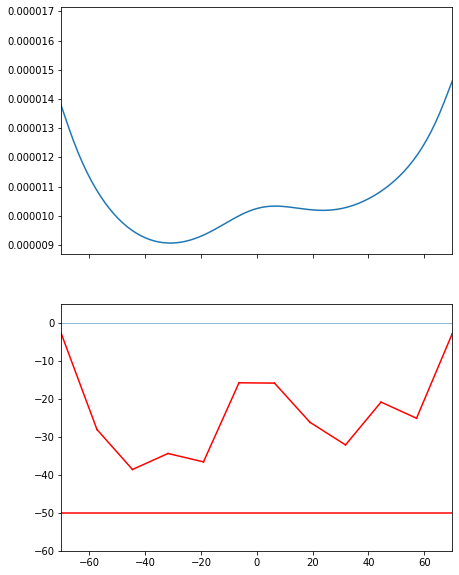

In [124]:
plot_true(points,70)

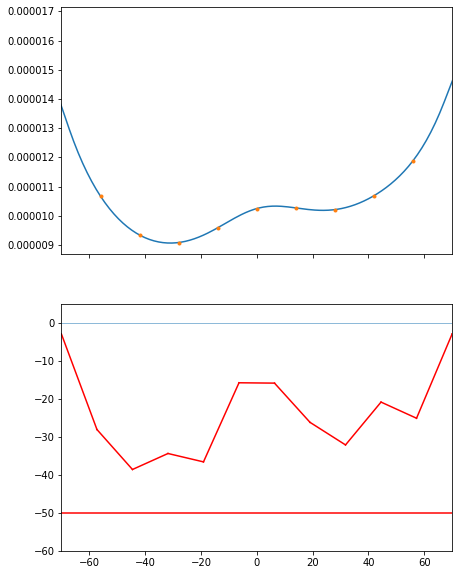

In [125]:
x_obs = np.linspace(-70., 70., 11)
x_obs = x_obs[1:-1]
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
obs_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [126]:
noise = norm(0,0.0000001).rvs(len(obs_data))
grav_obs_withnoise = obs_data+noise

9 observation points,10 parameters

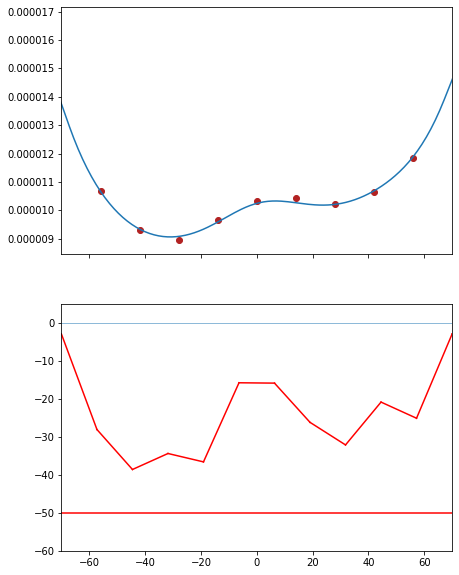

In [127]:
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
ax[0].scatter(x_obs,grav_obs_withnoise,color='firebrick')

In [24]:
dtype = tf.float32

In [25]:
obv_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [26]:
def grav(base,ps):
    
    #base_points:2xN tensor contains x location
    #ps: 1xN vector, elevation variate
    
    for i in range(N):
        base[i+4][1] = ps[i]
        
    x_obv = np.linspace(-70., 70., 11)
    y_obv = np.zeros(np.shape(x_obv))
    obv = np.vstack((x_obv,y_obv)).T
    
    gravity = []
    for i in obv[1:-1]:
        gravity.append(-g(base,i))
        
    return gravity

In [129]:
points

array([[-200.        ,  -50.        ],
       [ 200.        ,  -50.        ],
       [ 200.        ,   -3.        ],
       [  70.        ,   -3.        ],
       [  57.27272727,  -25.12845663],
       [  44.54545455,  -20.88000879],
       [  31.81818182,  -32.14557205],
       [  19.09090909,  -26.20765466],
       [   6.36363636,  -15.89043223],
       [  -6.36363636,  -15.8000866 ],
       [ -19.09090909,  -36.60919662],
       [ -31.81818182,  -34.40444229],
       [ -44.54545455,  -38.61038551],
       [ -57.27272727,  -28.09813422],
       [ -70.        ,   -3.        ],
       [-200.        ,   -3.        ]])

In [131]:
mu_prior = [-25,-20,-30,-25,-13,-13,-35,-35,-35,-30]
cov_prior = 10.*tf.eye(N)

sig_e = 0.001
cov = sig_e**2*tf.eye(np.shape(obv_data)[0])

\begin{equation}
\mathbf{e}=\mathbf{d}-\mathbf{G} \mathbf{m}=\mathbf{d}-\mathbf{G} \mathbf{A} \boldsymbol{\theta}
\end{equation}
\begin{equation}
p(\mathbf{d} | \boldsymbol{\theta}, \mathscr{J})=\frac{1}{\left(2 \pi \bar{\sigma}_{\mathbf{e}}^{2}\right)^{N / 2}} \exp \left(-\frac{\mathbf{e}^{\mathrm{T}} \mathbf{e}}{2 \bar{\sigma}_{\mathbf{e}}^{2}}\right)
\end{equation}

In [132]:
d = tf.convert_to_tensor(obv_data,dtype)
d

<tf.Tensor: id=35943519, shape=(9,), dtype=float32, numpy=
array([1.06675907e-05, 9.33764477e-06, 9.08058701e-06, 9.58567944e-06,
       1.02444201e-05, 1.02669665e-05, 1.02084741e-05, 1.06843372e-05,
       1.18830203e-05], dtype=float32)>

In [133]:
points_copy = points

In [134]:
def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps)
          +mvn_likelihood.log_prob(D))

In [135]:
cov

<tf.Tensor: id=35943518, shape=(9, 9), dtype=float32, numpy=
array([[1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-06, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-06, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-06, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-06,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        1.e-06]], dtype=float32)>

In [136]:
num_results = 5000
burnin = 1000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(obs_data,points_copy,*args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [137]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [171]:
accepted_samples[:,:,0].shape

(3139, 10)

In [139]:
import corner 

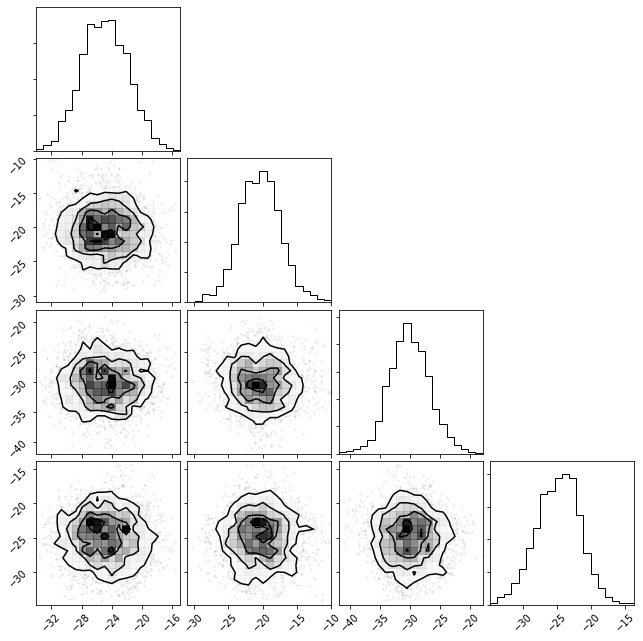

In [140]:
figure = corner.corner(accepted_samples[:,0:4,0])

TO DO:
1.  add a entropy plotting function
2.  compare with prior info and without
3.  Hessian MCMC

In [172]:
def draw_MCMC(base,samples,ax = None,R = 70):
    if ax == None:
        f,ax=plt.subplots()
    x = base[:,0]
    z = base[:,1]
    for i in range(base.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x_ = np.linspace(-R,R,N)
    for ps in samples:
        for j in range(N):
            base[j+4][1] = ps[j]
        for i in range(1,base.shape[0]):
            ax.plot(base[:,0][i:i+2],base[:,1][i:i+2],'r-',alpha = 0.01)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)

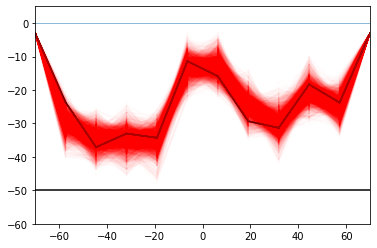

In [173]:
draw_MCMC(points,accepted_samples[:,:,0])